In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re
import textstat
import matplotlib.pyplot as plt
from langdetect import detect
import seaborn as sns

import collections
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
import scipy


#makes notebook wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/alessandro/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3



# Make CSV

In [20]:
#look at structure of txt file
with open("./Data/BeerAdvocate/ratings.txt") as f:
  for i,line in enumerate(f):
    print(line)
    if i>20:
      break

beer_name: Régab

beer_id: 142544

brewery_name: Societe des Brasseries du Gabon (SOBRAGA)

brewery_id: 37262

style: Euro Pale Lager

abv: 4.5

date: 1440064800

user_name: nmann08

user_id: nmann08.184925

appearance: 3.25

aroma: 2.75

palate: 3.25

taste: 2.75

overall: 3.0

rating: 2.88

text: From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse.

review: True



beer_name: Barelegs Brew

beer_id: 19590

brewery_name: Strangford Lough Brewing Company Ltd

brewery_id: 10093



In [7]:
#see how many lines the .txt file is, hence how many rows we can expect at the most the dataframe to have
l = 0
with open("./Data/BeerAdvocate/ratings.txt") as f:
  for i,line in enumerate(f):
    l+=1
    if i>151074570:
      print(line)
potential_length = l/18
print(l, potential_length)  #divide by 18 because there are 17 keys and every "row" is separated by a blank line (even at the end)

overall: 3.0

rating: 3.00

text: Dark brown brew served on tap at the brewpub. Half finger of dark tan head. Okay retention and lacing.Nutty malty aroma.Nutty, bready malty brewpub brown ale. Decent in its own right, with no overt flaws. However, I had a few others today that just had more depth and body. Tiny little bit of hops on the bottom. Smooth and easy on the mouth.

review: True



151074576 8393032.0


There are potentially 8393032 rows.

In [2]:
def txt_to_df(row_min, row_max, path="Data/BeerAdvocate/ratings.txt", keys=['brewery_id','beer_id','date','user_id','rating','text']):  #row min and row max because we need to do it in batches not to crash everything
  df_dict = {k: [] for k in keys}
  with open(path) as f:
    for i,line in enumerate(f):
      if i>=row_min*18 and i<=row_max*18-1:
        if line != '\n':
          key, value = line.rstrip().split(":", maxsplit=1)
          if key in df_dict.keys():     #I am only taking the features we'll probably use
            df_dict[key].append(value.strip())
  df = pd.DataFrame.from_dict(df_dict)  
  df[df=='nan'] = np.nan
  df = df.dropna(subset='text')         #We want reviews to have textual part
  return df

In [3]:
df1 = txt_to_df(0,3_000_000)
df2 = txt_to_df(3_000_000,6_000_000)
df3 = txt_to_df(6_000_000,9_000_000)

df = pd.concat([df1, df2, df3], ignore_index=True)
df

,brewery_id,beer_id,date,user_id,rating,text
0,37262,142544,1440064800,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ..."
1,10093,19590,1235127600,stjamesgate.163714,3.67,Pours pale copper with a thin head that quickl...
2,10093,19590,1142247600,mdagnew.19527,3.73,"500ml Bottle bought from The Vintage, Antrim....."
3,10093,19590,1101898800,helloloser12345.10867,3.98,Serving: 500ml brown bottlePour: Good head wit...
4,10093,19590,1093860000,cypressbob.3708,4.00,"500ml bottlePours with a light, slightly hazy ..."
...,...,...,...,...,...,...
2715707,885,19141,1100516400,ecoboy.1641,3.18,"It may say APA on this site, but talking to th..."
2715708,885,19139,1141038000,jaluria.31362,3.80,I'll start off reviewing this beer with the fo...
2715709,885,19139,1140346800,dithyramb.4413,2.80,Served on draft at the pub. Poured a clear yel...
2715710,885,19139,1092132000,manekineko.2654,1.54,Served on tap at the brewpub in a pint glass.A...


In [4]:
#check for other nan values (display rows with at least one nan)
df[df.isna().any(axis=1)]

,brewery_id,beer_id,date,user_id,rating,text


In [5]:
#there are no nans. We save the dataframe as a .csv file
df.to_csv('Data/ratings_ba.csv', encoding='utf-8', index=False)  #comment so I don't save tt again accidentally

In [8]:
print(f'We discarded {potential_length-len(df)} rows')

We discarded 5677320.0 rows


# Add number of reviews

### Check nbr_reviews and number of reviews counted from the dataset coincide (more or less)  [We are doing this "post hoc", since we found some reviews where the 'nbr_reviews' value we extracted from the users dataset was 0]

In [2]:
df = pd.read_csv('Data/ratings_ba.csv')
df.head()

,brewery_id,beer_id,date,user_id,rating,text
0,37262,142544,1440064800,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ..."
1,10093,19590,1235127600,stjamesgate.163714,3.67,Pours pale copper with a thin head that quickl...
2,10093,19590,1142247600,mdagnew.19527,3.73,"500ml Bottle bought from The Vintage, Antrim....."
3,10093,19590,1101898800,helloloser12345.10867,3.98,Serving: 500ml brown bottlePour: Good head wit...
4,10093,19590,1093860000,cypressbob.3708,4.00,"500ml bottlePours with a light, slightly hazy ..."


In [3]:
actual_nbr = df.groupby('user_id')['date'].count()
actual_nbr_df = pd.DataFrame({'user_id': actual_nbr.index, 'actual_nbr': actual_nbr.values})
actual_nbr_df

,user_id,actual_nbr
0,--dida--.1042029,3
1,--dom--.709199,54
2,--nomad--.931404,1
3,--weezl--.789708,8
4,-1x.1006554,3
...,...,...
76239,zytos.1045894,1
76240,zyxt.993924,1
76241,zz427.1113802,2
76242,zzombie.658444,1


In [5]:
users = pd.read_csv('Data/BeerAdvocate/users.csv')
reviews_id = users[['user_id', 'nbr_reviews']]
reviews_id = reviews_id[reviews_id['nbr_reviews']!=0] #Take those != 0 so we expec them to match with that extracted from review
reviews_id

,user_id,nbr_reviews
0,nmann08.184925,465
1,stjamesgate.163714,2504
2,mdagnew.19527,1143
3,helloloser12345.10867,31
4,cypressbob.3708,604
...,...,...
153694,quaffer83.125656,1
153699,everman.532342,1
153700,justin0001.352175,1
153702,joetex.800347,1


In [6]:
#check for nans
reviews_id[reviews_name['nbr_reviews'].isna()]

<ipython-input-6-700f15f7126c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_id[reviews_name['nbr_reviews'].isna()]


,user_id,nbr_reviews


In [7]:
actual_nbr_df[actual_nbr_df['actual_nbr'].isna()]

,user_id,actual_nbr


Just from the number of columns we see there is a discrepancy

In [8]:
check = actual_nbr_df.merge(reviews_id, on='user_id', how='outer')
check

,user_id,actual_nbr,nbr_reviews
0,--dida--.1042029,3,NaN
1,--dom--.709199,54,53.0
2,--nomad--.931404,1,NaN
3,--weezl--.789708,8,3.0
4,-1x.1006554,3,NaN
...,...,...,...
76239,zytos.1045894,1,1.0
76240,zyxt.993924,1,1.0
76241,zz427.1113802,2,2.0
76242,zzombie.658444,1,1.0


In [9]:
#let's be generour and drop nan
check = check.dropna()

In [11]:
len(check)

62252

<AxesSubplot:>

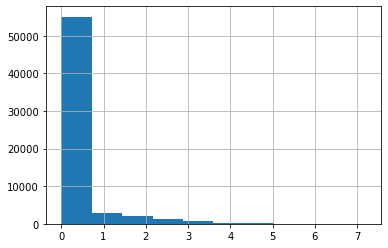

In [10]:
np.log((check['actual_nbr']-check['nbr_reviews'])+1).hist()

Most of them are pretty close, but still some quite distant. Moreover we discarded ~10K rows to use the nbr_reviews taken from the users dataset.

We think it is therefore better to use the number of reviews extracted from the dataframe.

In [4]:
#restart fresh for safety
df = pd.read_csv('Data/ratings_ba.csv')
df

,brewery_id,beer_id,date,user_id,rating,text
0,37262,142544,1440064800,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ..."
1,10093,19590,1235127600,stjamesgate.163714,3.67,Pours pale copper with a thin head that quickl...
2,10093,19590,1142247600,mdagnew.19527,3.73,"500ml Bottle bought from The Vintage, Antrim....."
3,10093,19590,1101898800,helloloser12345.10867,3.98,Serving: 500ml brown bottlePour: Good head wit...
4,10093,19590,1093860000,cypressbob.3708,4.00,"500ml bottlePours with a light, slightly hazy ..."
...,...,...,...,...,...,...
2715707,885,19141,1100516400,ecoboy.1641,3.18,"It may say APA on this site, but talking to th..."
2715708,885,19139,1141038000,jaluria.31362,3.80,I'll start off reviewing this beer with the fo...
2715709,885,19139,1140346800,dithyramb.4413,2.80,Served on draft at the pub. Poured a clear yel...
2715710,885,19139,1092132000,manekineko.2654,1.54,Served on tap at the brewpub in a pint glass.A...


In [5]:
actual_nbr = df.groupby('user_id')['date'].count()
actual_nbr_df = pd.DataFrame({'user_id': actual_nbr.index, 'nbr_reviews': actual_nbr.values})
df = df.merge(actual_nbr_df, on='user_id', how='outer')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews
0,37262,142544,1440064800,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465
1,31221,131646,1409306400,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465
2,31221,99556,1409306400,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465
3,31221,127138,1409306400,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465
4,31221,135343,1409306400,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465
...,...,...,...,...,...,...,...
2715707,23640,70471,1397383200,everman.532342,4.54,"While it is a double IPA, the hops presence is...",1
2715708,23640,61818,1309168800,justin0001.352175,2.08,"San Diego has countless fantastic taco shops, ...",1
2715709,23640,61817,1443952800,kyungsup.982216,5.00,Better than Sculpin. Beilieve it?,1
2715710,23640,61815,1400234400,joetex.800347,4.45,This is a great session beer. You can drink th...,1


In [6]:
#checkpoint
df.to_csv('Data/checkpoint1.csv', index=False)   #encoding is by default utf-8 

# Clean on country  

In [2]:
users = pd.read_csv('Data/BeerAdvocate/users.csv')
users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


In [3]:
df = pd.read_csv('Data/checkpoint1.csv')  #decoding is by default utf-8 
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews
0,37262,142544,1440064800,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465
1,31221,131646,1409306400,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465
2,31221,99556,1409306400,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465
3,31221,127138,1409306400,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465
4,31221,135343,1409306400,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465
...,...,...,...,...,...,...,...
2715707,23640,70471,1397383200,everman.532342,4.54,"While it is a double IPA, the hops presence is...",1
2715708,23640,61818,1309168800,justin0001.352175,2.08,"San Diego has countless fantastic taco shops, ...",1
2715709,23640,61817,1443952800,kyungsup.982216,5.00,Better than Sculpin. Beilieve it?,1
2715710,23640,61815,1400234400,joetex.800347,4.45,This is a great session beer. You can drink th...,1


In [4]:
#add location of user column
users_loc_id = users[['location', 'user_id']]
df = df.merge(users_loc_id, how='outer', on='user_id')   #here and often in the notebook we could have done an inner join instead of outer+dropna()
df = df.rename(columns={'location':'location_user'})     #we did it so because this way it is easier to spot errors and we feel we have a better grasp of what is happening
#check for nan
df[df.isna().any(axis=1)]

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user
63553,10093.0,19827.0,1.279274e+09,bump8628.197033,3.85,Dark amber with a thin but persistent off-whit...,723.0,NaN
63554,10093.0,20842.0,1.281348e+09,bump8628.197033,3.40,Dark amber with a quick-rising head of off-whi...,723.0,NaN
63555,24.0,36.0,1.346926e+09,bump8628.197033,4.27,"Not many good Scotch Ales available here, but ...",723.0,NaN
63556,148.0,1163.0,1.269515e+09,bump8628.197033,4.00,12ozer poured into a pint.Clear amber with a b...,723.0,NaN
63557,148.0,48194.0,1.266750e+09,bump8628.197033,3.16,Pitch black with a creamy nitro-pour light tan...,723.0,NaN
...,...,...,...,...,...,...,...,...
2793167,NaN,NaN,NaN,lflk.690399,NaN,NaN,NaN,NaN
2793168,NaN,NaN,NaN,egroves.813240,NaN,NaN,NaN,"United States, Michigan"
2793169,NaN,NaN,NaN,llgarrity.884995,NaN,NaN,NaN,NaN
2793170,NaN,NaN,NaN,lgkiii.1077659,NaN,NaN,NaN,"United States, California"


In [5]:
#Eliminate NaNs (some are of users with no reviews and some of reviews whose user we don't know the location)
len1 = len(df)
df = df.dropna()
print(f'we discarded {len1-len(df)} rows')
df

we discarded 184378 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,"United States, Washington"
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,"United States, Washington"
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,"United States, Washington"
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,"United States, Washington"
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,"United States, Washington"
...,...,...,...,...,...,...,...,...
2715706,565.0,4474.0,1.176113e+09,quaffer83.125656,3.40,I'd call the overall character roasty. Not ver...,1.0,"United States, Michigan"
2715707,23640.0,70471.0,1.397383e+09,everman.532342,4.54,"While it is a double IPA, the hops presence is...",1.0,"United States, California"
2715708,23640.0,61818.0,1.309169e+09,justin0001.352175,2.08,"San Diego has countless fantastic taco shops, ...",1.0,"United States, California"
2715710,23640.0,61815.0,1.400234e+09,joetex.800347,4.45,This is a great session beer. You can drink th...,1.0,"United States, California"


<AxesSubplot:xlabel='location_user'>

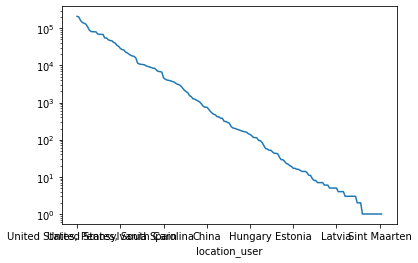

In [6]:
#Out of curiosity look at the distribution of reviews by country
nmbr_reviews = df.groupby('location_user')['rating'].count().sort_values(ascending=False)
nmbr_reviews.plot(logy=True)  #It is quite a perfect exponential. Might be a good idea to keep the first 1/tau reviews

In [7]:
def linear(x,a,b):
  return a + b*x

def exponential(x,a,b):
  return np.exp(a+b*x)

(a,b),_ = curve_fit(linear, np.arange(len(nmbr_reviews)), np.log(nmbr_reviews))
b

-0.07103452519577157

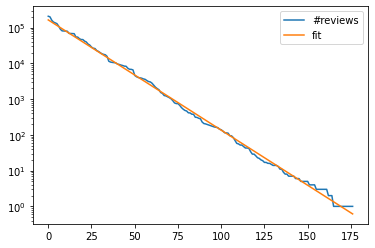

In [8]:
x = np.arange(len(nmbr_reviews))
plt.semilogy(x, nmbr_reviews, label='#reviews')
plt.semilogy(x, exponential(x,a,b), label='fit')
plt.legend()

#### To make our job easier down the road we group US states by area

In [9]:
a = {
    'Central and Eastern Europe': ['Belarus', 'Moldova', 'Romania', 'Russia', 'Ukraine', 'Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Kosovo',
    'Montenegro', 'North Macedonia', 'Serbia', 'Slovenia', 'Czech Republic', 'Hungary', 'Poland', 'Slovakia', 'Macedonia', 'Slovak Republic'],
    #
    'Northern Europe': ['Denmark', 'Finland', 'Iceland', 'Ireland', 'Norway',
    'Sweden', 'England', 'Estonia', 'Latvia', 'Lithuania', 'Northern Ireland', 'Scotland', 'Wales',
    'Svalbard and Jan Mayen Islands', 'Faroe Islands'],
    #
    'Western Europe': ['Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein',
    'Luxembourg', 'Monaco', 'Netherlands', 'Switzerland'],
    #
    'Southern Europe': ['Andorra', 'Cyprus', 'Greece', 'Italy', 'Malta',
    'Portugal', 'San Marino', 'Spain', 'Vatican City'],
  #
  'Asia': ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China',
           'East Timor', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan',
           'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea',
           'Oman', 'Pakistan', 'Palestine', 'Philippines', 'Qatar', 'Saudi', 'Arabia', 'Singapore', 'South Korea',
           'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan',
           'Vietnam', 'Yemen', 'Hong Kong', 'Heard and McDonald Islands'],
  
  'Africa': ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
             'Chad', 'Comoros', 'Congo', 'Democratic Republic of the Congo', "Republic of the Cote d'Ivoire", 'Djibouti', 'Egypt',
             'Equatorial', 'Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea-Bissau',
             'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique',
             'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia',
             'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'],
  
  'South America': ['Argentina' ,'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela',
                   'Trinidad and Tobago'],
  
  'Central America': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Puerto Rico'],
  'Oceania': ['Australia', 'Papua New Guinea', 'Dominican Republic', 'Aotearoa', 'Guam', 'Fiji Islands']
  
}

a1 = {}

for k,v in a.items():
  for element in v:
    a1[element] = k
    
b = {
    'Washington': 'West Coast', 'Oregon': 'West Coast', 'California': 'West Coast', 'Nevada': 'West Coast',
    'Arizona': 'West Coast',
    #
    'Alaska': 'Non-Contiguous', 'Hawaii': 'Non-Contiguous', 'Bahamas': 'Non-Contiguous', 'Bahamas': 'Non-Contiguous',
    #
    'Idaho': 'Central', 'Montana': 'Central', 'Wyoming': 'Central', 'Utah': 'Central', 'Nebraska': 'Central',
    'Colorado': 'Central', 'New Mexico': 'Central', 'North Dakota': 'Central', 'South Dakota': 'Central', 'Kansas': 'Central',
    #
    'Maine': 'East Coast', 'Vermont': 'East Coast', 'New York': 'East Coast', 'New Hampshire': 'East Coast',
    'Massachusetts': 'East Coast', 'Rhode Island': 'East Coast', 'Connecticut': 'East Coast',
    'New Jersey': 'East Coast', 'Pennsylvania': 'East Coast', 'Maryland': 'East Coast', 'Delaware': 'East Coast',
    'Jersey': 'East Coast',
    #
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    #
    'West Virginia': 'South', 'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 
    'North Carolina': 'South', 'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 
    'Alabama': 'South', 'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 
    'Oklahoma': 'South', 'Texas': 'South'

}


#inverting the dictionaty
b1 = {}
for k,v in b.items():
  b1['United States, '+k] = v
  

#mergin dictionaries
country_to_area = {**a1,**b1}

#some were missing, adding them manually
country_to_area['Jersey'] = 'East Coast' 
country_to_area['Bahamas'] = 'Non-Contuguous' 


In [11]:
def make_area(key, cta=country_to_area):
  try:
    return cta[key]   
  except(KeyError):    #If country is not in keys, it is either too small to bother, or an area on its own (i.e. Canada)
    return key

In [12]:
df['location_user'] = df['location_user'].apply(lambda state: make_area(state))
df = df.reset_index(drop=True)
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast
...,...,...,...,...,...,...,...,...
2608789,565.0,4474.0,1.176113e+09,quaffer83.125656,3.40,I'd call the overall character roasty. Not ver...,1.0,Midwest
2608790,23640.0,70471.0,1.397383e+09,everman.532342,4.54,"While it is a double IPA, the hops presence is...",1.0,West Coast
2608791,23640.0,61818.0,1.309169e+09,justin0001.352175,2.08,"San Diego has countless fantastic taco shops, ...",1.0,West Coast
2608792,23640.0,61815.0,1.400234e+09,joetex.800347,4.45,This is a great session beer. You can drink th...,1.0,West Coast


<AxesSubplot:xlabel='location_user'>

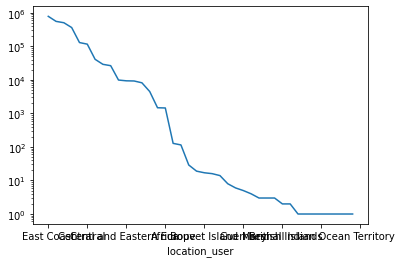

In [13]:
# See if distribution changed qualitatively
nmbr_reviews = df.groupby('location_user')['rating'].count().sort_values(ascending=False)
nmbr_reviews.plot(logy=True)

In [14]:
nmbr_reviews.head(60)  #It's not time efficient to add all those locations with 1 review, we'll just get rid of them

location_user
East Coast                                  788666
Midwest                                     557923
South                                       508349
West Coast                                  365239
Canada                                      130195
Central                                     116772
Northern Europe                              41213
Western Europe                               29197
Oceania                                      26588
Non-Contiguous                                9922
Central and Eastern Europe                    9405
Southern Europe                               9297
Asia                                          8207
Central America                               4504
South America                                 1479
Africa                                        1456
Non-Contuguous                                 128
Antarctica                                     115
Isle of Man                                     29
American Samoa   

A reasonable cutoff seems at Non-Contiguous (included) so that we have all of the US

In [15]:
len1 = len(df)
ok_areas = nmbr_reviews[nmbr_reviews>120].index
df = df[df['location_user'].isin(ok_areas)]
df = df.reset_index(drop=True)
print(f' we discarded {len1-len(df)} rows')
df

 we discarded 254 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast
...,...,...,...,...,...,...,...,...
2608535,565.0,4474.0,1.176113e+09,quaffer83.125656,3.40,I'd call the overall character roasty. Not ver...,1.0,Midwest
2608536,23640.0,70471.0,1.397383e+09,everman.532342,4.54,"While it is a double IPA, the hops presence is...",1.0,West Coast
2608537,23640.0,61818.0,1.309169e+09,justin0001.352175,2.08,"San Diego has countless fantastic taco shops, ...",1.0,West Coast
2608538,23640.0,61815.0,1.400234e+09,joetex.800347,4.45,This is a great session beer. You can drink th...,1.0,West Coast


# Beer location

In [16]:
breweries = pd.read_csv('Data/BeerAdvocate/breweries.csv')
breweries = breweries.rename(columns={'id': 'brewery_id'})
breweries
#Then do an outer merge, but first need to redo the dataframe

,brewery_id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16754,5023,Aruba,Aruba Brewing,0
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491
16756,16186,"United States, North Carolina",Triangle Brewing Company,20


In [19]:
#check for duplicates
print(len(breweries['brewery_id']), len(set(breweries['brewery_id'])))
#There are no duplicates

16758 16758


In [20]:
df = df.merge(breweries[['location','brewery_id']], on='brewery_id', how='outer')
len1 = len(df)
df = df.dropna()   #nans are from breweries with 0 beers
print(f'we discarded {len1-len(df)} rows')
df = df.rename(columns={'location': 'location_brewery'})
#make area location_brewery as well
df['location_brewery'] = df['location_brewery'].apply(lambda state: make_area(state))
df

we discarded 4758 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe
...,...,...,...,...,...,...,...,...,...
2608535,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe
2608536,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia"
2608537,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central
2608538,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast


#### location brewerie == location user

In [21]:
df['location_match'] = (df['location_brewery'] == df['location_user']).astype(int)
print(df['location_match'].sum()/len(df['location_match']))  #~37% of reviews have area of brewery and user that match
df

0.3748253812477478


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0
...,...,...,...,...,...,...,...,...,...,...
2608535,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1
2608536,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0
2608537,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0
2608538,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0


In [22]:
# checkpoint2
df.to_csv('Data/checkpoint2.csv', index=False)

# NLP

In [2]:
from html.parser import HTMLParser


class HTMLTagsRemover(HTMLParser):
    def __init__(self):
        super().__init__(convert_charrefs=False)
        self.reset()
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, data):
        self.fed.append(data)

    def handle_entityref(self, name):
        self.fed.append(f'&{name};')

    def handle_charref(self, name):
        self.fed.append(f'{name};')

    def get_data(self):
        return ''.join(self.fed)


def remove_html_tags(value):
    remover = HTMLTagsRemover()

    remover.feed(value)
    remover.close()
    return remover.get_data()

#try it

html_string = """

  

    
Apple

    
Banana

    
Kiwi

  

"""

# Apple
# Banana
# Kiwi
print(remove_html_tags(html_string))



  

    
Apple

    
Banana

    
Kiwi

  




In [15]:
def check_eng(sentence):    #Keep only sensible english reviews
  try:
    if detect(sentence)=='en':
      return True
    else:
      return False
  except:          #When detect encounters a sentence with no letters, it can't detect the language and gives a LangDetectException. Since we want to eliminate those reviews without words,                 #
    return False   #of which it wouldn't be sensible to calculate the complexity, we eliminate them. We can't explicitly put LangDetectException as the exception because it is not recognised
                   #and gives NameError. A more explicit, but less elegant solution is commented below. We checked on a subset that they work the same

# def check_eng(sentence):
#   try:
#     try:
#       if detect(sentence)=='en':
#         return True
#       else:
#         return False
#     except(LangDetectException):
#       return False
#   except(NameError):
#     return False

In [4]:
df = pd.read_csv('Data/checkpoint2.csv')
df.head(10)

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0
5,31221.0,120799.0,1.409306e+09,nmann08.184925,3.25,"On draft, pours a hazy pale yellow, very froth...",465.0,West Coast,Northern Europe,0
6,31221.0,133715.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a slightly hazy pale orange, w...",465.0,West Coast,Northern Europe,0
7,31221.0,125211.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a slightly hazy gold yellow, g...",465.0,West Coast,Northern Europe,0
8,31221.0,176173.0,1.439374e+09,stjamesgate.163714,3.89,"On tap at Black Sheep, Dublin.Dark amber with ...",2504.0,East Coast,Northern Europe,0
9,31221.0,273192.0,1.490094e+09,stjamesgate.163714,4.22,"Oxblood with speckles. 4Huge dank, mulchy, wee...",2504.0,East Coast,Northern Europe,0


In [5]:
#remove html tags
df['text'] = df['text'].apply(lambda x: remove_html_tags(x))
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0
...,...,...,...,...,...,...,...,...,...,...
2608535,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1
2608536,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0
2608537,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0
2608538,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0


In [6]:
#remove non-english reviews and those where the function detect from langdetect can't "see" words (there are some reviews which are just a date or '-')
len1 = len(df)
df = df[df['text'].apply(lambda x: check_eng(x))]
print(f'we discarded {len1-len(df)} rows')
df

we discarded 10719 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0
...,...,...,...,...,...,...,...,...,...,...
2608535,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1
2608536,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0
2608537,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0
2608538,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0


For info about flesch reading score and dale chall readibility score look at

https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

and

https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula

<ipython-input-7-656bee07f8c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flesch_reading_ease'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x))


<AxesSubplot:>

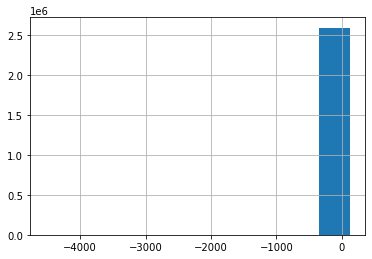

In [7]:
df['flesch_reading_ease'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x))
df['flesch_reading_ease'].hist()

<ipython-input-8-741ef10b53eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dale_chall_readability_score'] = df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))


<AxesSubplot:>

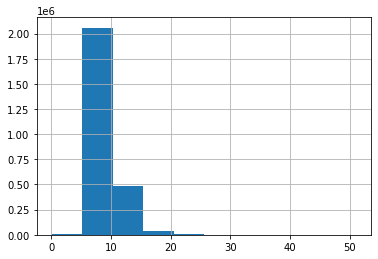

In [8]:
df['dale_chall_readability_score'] = df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['dale_chall_readability_score'].hist()

<ipython-input-9-f2cd8faae1ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(lambda x: textstat.lexicon_count(x))


<AxesSubplot:>

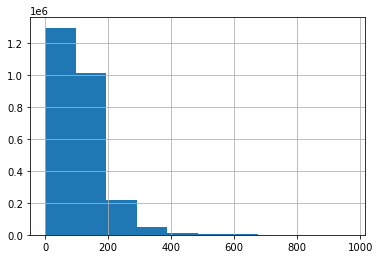

In [9]:
df['text_length'] = df['text'].apply(lambda x: textstat.lexicon_count(x))
df['text_length'].hist()

In [10]:
#checkpoint 2.1
df = df.reset_index(drop=True)
df.to_csv('Data/checkpoint2_1.csv', index=False)

In [11]:
#there clearly are outliers that skew the distribution, let's see an example
df.loc[df['flesch_reading_ease'].idxmin(),'text']

'onetwothreefourfivesixseveneightnineteneleventwelvethirteenfourteenfifteensixteenseventeeneighteennineteentwentywhydoIhavetowriteareviewofatleast250charactersIfeellikeIaminschooltwentyonetwentytwotwentythreetwentyfourtwentyfivetwentysixtwentyseventwentyeighttwentyninethirty'

In [16]:
df.loc[df['dale_chall_readability_score'].idxmax(),'text']
#The 'Bottled' in the middle "tricked" the detect algorithm

'03/12/2016Bottled 07.13.2015'

This are clearly not a reviews we can accurately determine the complexity of, hence we will discard them by removing the outliers (>3std from the mean)

In [17]:
#we only keep the rows within 3 standard deviation from the mean for both scores
len1 = len(df)
df = df[(np.abs(stats.zscore(df[['flesch_reading_ease','dale_chall_readability_score']])) < 3).all(axis=1)]
print(f'We dropped {len1-len(df)} columns')
df

We dropped 66956 columns


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,59
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,83
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,60
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0,19.38,10.72,68
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0,10.92,10.72,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597816,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,7
2597817,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,52
2597818,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,130
2597819,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,38


<AxesSubplot:>

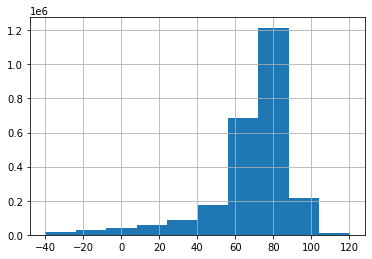

In [19]:
#redo histograms to check
df['flesch_reading_ease'].hist()

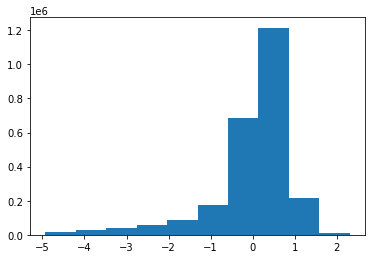

0          3.350255
1          3.047850
2          3.582407
3          2.964242
4          2.390596
             ...   
2597816    4.669740
2597817    4.569336
2597818    4.315219
2597819    4.155126
2597820    4.205886
Name: flesch_reading_ease, Length: 2530865, dtype: float64


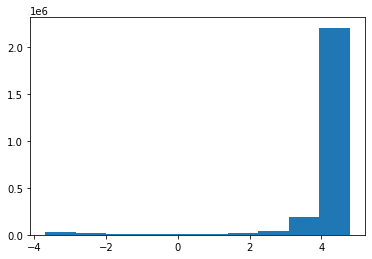

In [18]:
#see if better to make flesch_reading_ease in log or simply normalize
b = df['flesch_reading_ease'].copy()
b = (b-np.mean(b))/np.std(b)
plt.hist(b)
plt.show()

a = df['flesch_reading_ease'].copy()
negative = a<0
a = np.log(np.abs(a))
a[negative] = -a[negative]
print(a)
plt.hist(a)
plt.show()

It is better to simply normalize. The normalization will be done for all features later

<AxesSubplot:>

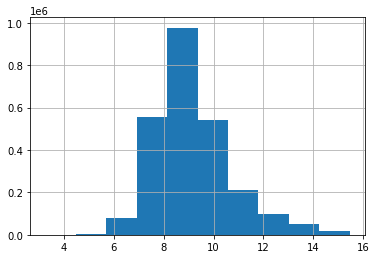

In [20]:
df['dale_chall_readability_score'].hist()
#looks good as is, we'll just normlize it after

(array([   1640.,   11355.,   31281.,   44233.,  154848.,  730847.,
        1030442.,  448981.,   72238.,    5000.]),
 array([0.69314718, 1.31125231, 1.92935744, 2.54746258, 3.16556771,
        3.78367284, 4.40177797, 5.0198831 , 5.63798823, 6.25609336,
        6.8741985 ]),
 <BarContainer object of 10 artists>)

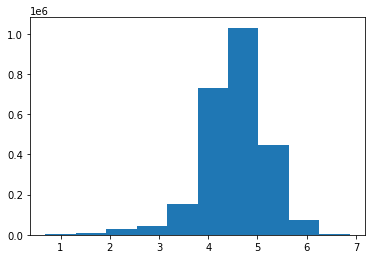

In [21]:
#see if take log of text length
plt.hist(np.log(df['text_length']))

In [22]:
#sice length of reviews is ~log_normal, we actually save the log
df['text_length'] = np.log(df['text_length'])
df = df.rename(columns={'text_lenght': 'log_text_length'})
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,4.077537
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0,19.38,10.72,4.219508
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0,10.92,10.72,4.219508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597816,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,1.945910
2597817,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,3.951244
2597818,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,4.867534
2597819,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,3.637586


In [23]:
#checkpoint 3
df = df.reset_index(drop=True)
df.to_csv('Data/checkpoint3.csv', index=False) #encoding is default utf-8

# Time

In [2]:
df = pd.read_csv('Data/checkpoint3.csv')  #decoding is default utf-8
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,4.077537
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345
3,31221.0,127138.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a translucent but very dark re...",465.0,West Coast,Northern Europe,0,19.38,10.72,4.219508
4,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0,10.92,10.72,4.219508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530860,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,1.945910
2530861,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,3.951244
2530862,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,4.867534
2530863,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,3.637586


In [4]:
first_review_time = df.groupby('beer_id')['date'].min()
first_review_time_df = pd.DataFrame(data={'beer_id':first_review_time.index, 'time0':first_review_time.values})
first_review_time_df

,beer_id,time0
0,3.0,1.019038e+09
1,4.0,1.018001e+09
2,5.0,9.945864e+08
3,6.0,9.835308e+08
4,7.0,1.003486e+09
...,...,...
166418,293264.0,1.500890e+09
166419,293274.0,1.500890e+09
166420,293279.0,1.500890e+09
166421,293281.0,1.500890e+09


In [5]:
df = df.merge(first_review_time_df, on='beer_id', how='outer')
len1 = len(df)
df = df.dropna()
print(f'we discarded {len1-len(df)} rows') #just to check
df

we discarded 0 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,4.077537,1.440065e+09
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09
2,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09
3,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09
4,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530860,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,1.945910,1.490353e+09
2530861,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,3.951244,1.293448e+09
2530862,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,4.867534,1.389611e+09
2530863,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,3.637586,1.400839e+09


In [7]:
df['relative_time'] = df['date'] - df['time0']
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,4.077537,1.440065e+09,0.0
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0
2,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0
3,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0
4,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530860,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,1.945910,1.490353e+09,0.0
2530861,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,3.951244,1.293448e+09,0.0
2530862,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,4.867534,1.389611e+09,0.0
2530863,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,3.637586,1.400839e+09,0.0


<AxesSubplot:>

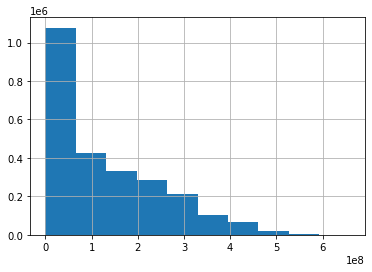

In [8]:
df['relative_time'].hist()

Look for a scaling that makes it somewhat normal

<AxesSubplot:>

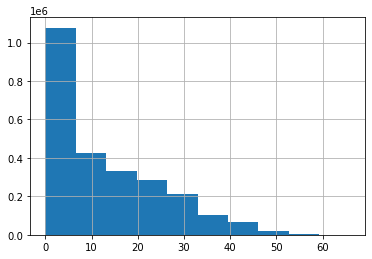

In [9]:
#change of unit of measure
(df['relative_time']/10**7).hist() 

<AxesSubplot:>

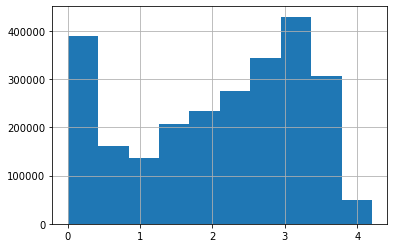

In [10]:
#change in unit of measure plus log_scalization
(np.log(df['relative_time']/10**7+1)).hist()

<AxesSubplot:>

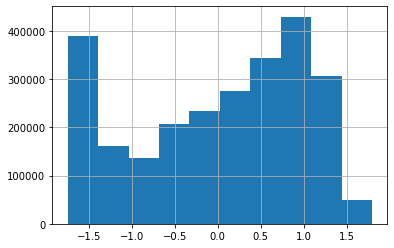

In [11]:
# ... + normalization
b = (np.log(df['relative_time']/10**7+1))
((b-b.mean())/b.std()).hist()

<AxesSubplot:>

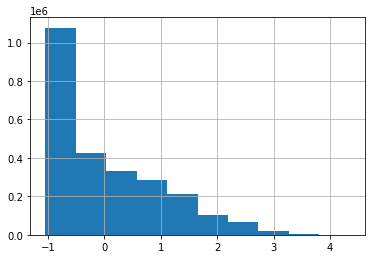

In [12]:
#normalize
((df['relative_time']-df['relative_time'].mean())/df['relative_time'].std()).hist()


<AxesSubplot:>

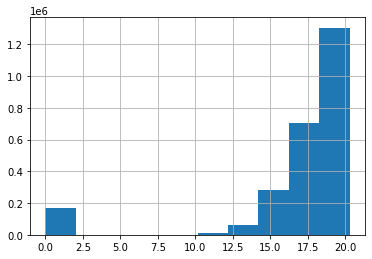

In [13]:
#log-scaling
np.log(df['relative_time']+1).hist()   # +1 so we don't get -inf for 0
# df['log_relative_time'] = np.log(df['relative_time']+1) # +1 so we don't get -inf for 0
# df['log_relative_time'].hist()


<AxesSubplot:>

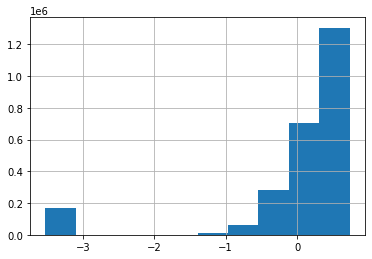

In [14]:
#log scaling + normalization
a = np.log(df['relative_time']+1) 
((a-a.mean())/a.std()).hist()

In [15]:
#change of unit of measure + log-scaling is best
df['log_scaled_relative_time'] = np.log(df['relative_time']/10**7+1)

<AxesSubplot:>

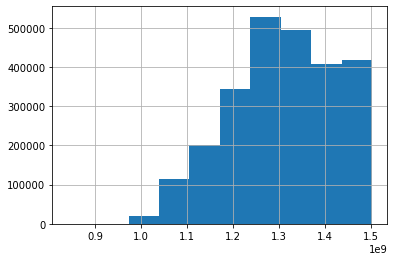

In [16]:
#see if take log or log+scale or scale of date
df['date'].hist()

<AxesSubplot:>

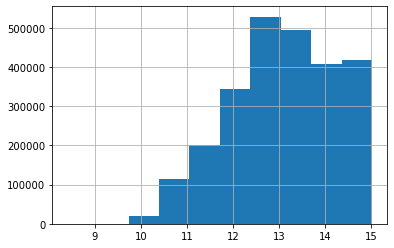

In [17]:
a = df['date']/10**8
a.hist()

<AxesSubplot:>

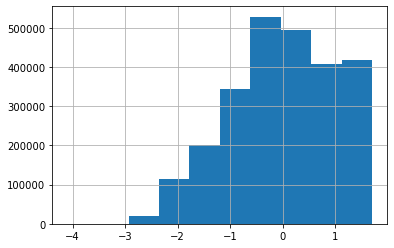

In [18]:
((a-a.mean())/a.std()).hist()

<AxesSubplot:>

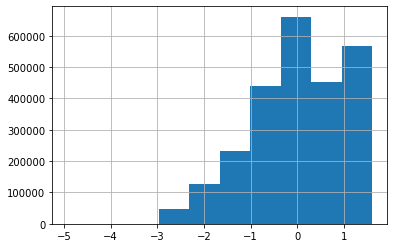

In [19]:
b = np.log(df['date']/10**8)
((b-b.mean())/b.std()).hist()

In [20]:
#They are quite similar, for consistency  we take log+scale
df['log_scaled_absolute_time'] = np.log(df['date']/10**8)

In [21]:
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,4.077537,1.440065e+09,0.0,0.000000,2.667273
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683
2,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643
3,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683
4,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530860,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,1.945910,1.490353e+09,0.0,0.000000,2.701598
2530861,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,3.951244,1.293448e+09,0.0,0.000000,2.559896
2530862,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,4.867534,1.389611e+09,0.0,0.000000,2.631609
2530863,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,3.637586,1.400839e+09,0.0,0.000000,2.639657


In [23]:
#checkpoint 4
df = df.reset_index(drop=True)
df.to_csv('Data/checkpoint4.csv', index=False)

In [24]:
len(df)

2530865

# Remove beers with <=1 review 
They will always rating_diff=0 and will just bring confusion to the model

In [2]:
df = pd.read_csv('Data/checkpoint4.csv')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time
0,37262.0,142544.0,1.440065e+09,nmann08.184925,2.88,"From a bottle, pours a piss yellow color with ...",465.0,West Coast,Africa,0,28.51,10.31,4.077537,1.440065e+09,0.0,0.000000,2.667273
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683
2,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643
3,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683
4,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530860,48440.0,268727.0,1.490353e+09,florian123.1195049,4.68,Great triple tasty and full of flavors,1.0,Western Europe,Western Europe,1,106.67,10.75,1.945910,1.490353e+09,0.0,0.000000,2.701598
2530861,21407.0,53754.0,1.293448e+09,bermin.181281,4.22,All cascade IPA. great nose and not over power...,1.0,Canada,"Canada, British Columbia",0,96.48,8.32,3.951244,1.293448e+09,0.0,0.000000,2.559896
2530862,29646.0,110418.0,1.389611e+09,pidgurtle.746608,3.34,Unfortunately I'm not too savvy with the techn...,1.0,West Coast,Central,0,74.83,9.33,4.867534,1.389611e+09,0.0,0.000000,2.631609
2530863,34425.0,122104.0,1.400839e+09,djsali.801480,5.00,Awesome brew. I look forward to my next opport...,1.0,Midwest,West Coast,0,63.76,10.25,3.637586,1.400839e+09,0.0,0.000000,2.639657


In [3]:
number_reviews_left = df.groupby('beer_id')['rating'].count()
number_reviews_left_df = pd.DataFrame(data={'beer_id':number_reviews_left.index, 'number_reviews_left':number_reviews_left.values})
number_reviews_left_df

,beer_id,number_reviews_left
0,3.0,3
1,4.0,10
2,5.0,547
3,6.0,997
4,7.0,827
...,...,...
166418,293264.0,1
166419,293274.0,1
166420,293279.0,2
166421,293281.0,1


In [4]:
df = df.merge(number_reviews_left_df, on='beer_id', how='outer')
len1 = len(df)
df = df[df['number_reviews_left']>1]
print(f'we dropped {len1-len(df)} rows')
df

we dropped 73071 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left
1,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2
2,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2
3,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28
4,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28
5,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,42.04,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530840,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,51.52,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2
2530844,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,34.59,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2
2530845,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,73.51,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2
2530856,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,76.66,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2


In [5]:
df = df.reset_index(drop=True)
df.to_csv('Data/checkpoint5.csv', index=False)

# Make Ys
Here we do both the binary and continuous target. We'll end up using only the continuous one

In [2]:
df = pd.read_csv('Data/checkpoint5.csv')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,42.04,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,51.52,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,34.59,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,73.51,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,76.66,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2


In [3]:
average_rating = df.groupby('beer_id')['rating'].mean()
average_rating_df = pd.DataFrame(data={'beer_id':average_rating.index, 'average_rating':average_rating.values})
average_rating_df

,beer_id,average_rating
0,3.0,4.106667
1,4.0,3.639000
2,5.0,3.391737
3,6.0,3.646279
4,7.0,3.212938
...,...,...
93347,292909.0,3.810000
93348,292982.0,4.355000
93349,292983.0,4.375000
93350,292990.0,4.706667


In [4]:
df = df.merge(average_rating_df, on='beer_id', how='outer')
len1 = len(df)
df = df.dropna()
print(f'we discarded {len1-len(df)} rows')  #we should get 0, just to check
df

we discarded 0 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left,average_rating
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2,3.7500
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2,3.7500
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28,4.0525
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28,4.0525
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,42.04,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28,4.0525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,51.52,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2,4.0350
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,34.59,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2,4.3450
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,73.51,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2,4.3450
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,76.66,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2,3.4200


In [5]:
df['rating_diff'] = df['rating'] - df['average_rating']
df.head()

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,flesch_reading_ease,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left,average_rating,rating_diff
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,21.07,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2,3.7500,-0.2500
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,59.33,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2,3.7500,0.2500
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,35.96,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28,4.0525,-0.0525
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,66.27,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28,4.0525,-0.5325
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,42.04,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28,4.0525,0.4975


There will still be some reviews whose rating is the same as the average rating by pure chence. We'll keep them as 0 for the binary Y and then remove them later so we can keep everything in the same dataframe

In [9]:
df['lower/higher'] = np.sign(df['rating_diff'])
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left,average_rating,rating_diff,lower/higher
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,...,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2,3.7500,-0.2500,-1.0
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,...,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2,3.7500,0.2500,1.0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,...,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28,4.0525,-0.0525,-1.0
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,...,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28,4.0525,-0.5325,-1.0
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,...,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28,4.0525,0.4975,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,...,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2,4.0350,0.0550,1.0
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,...,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2,4.3450,-0.2350,-1.0
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,...,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2,4.3450,0.2350,1.0
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,...,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2,3.4200,0.2200,1.0


In [10]:
#checkpoint 6
df = df.reset_index(drop=True)
df.to_csv('Data/checkpoint6.csv', index=False)

# Prepare for fit

### Make location_user 1-hot

In [2]:
df = pd.read_csv('Data/checkpoint6.csv')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left,average_rating,rating_diff,lower/higher
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,...,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2,3.7500,-0.2500,-1.0
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,...,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2,3.7500,0.2500,1.0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,...,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28,4.0525,-0.0525,-1.0
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,...,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28,4.0525,-0.5325,-1.0
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,...,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28,4.0525,0.4975,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,...,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2,4.0350,0.0550,1.0
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,...,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2,4.3450,-0.2350,-1.0
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,...,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2,4.3450,0.2350,1.0
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,...,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2,3.4200,0.2200,1.0


In [3]:
for country in df['location_user'].unique():
  df[country] = (df['location_user']==country).astype(int)
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,Southern Europe,South,Asia,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,...,0,0,0,0,0,0,0,0,0,0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,...,0,0,0,0,0,0,0,0,0,0
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,...,0,0,0,0,0,0,0,0,0,0
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,...,0,0,0,0,0,0,0,0,0,0
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,...,0,0,1,0,0,0,0,0,0,0


In [4]:
#check ok
df.iloc[0]

brewery_id                                                                31221.0
beer_id                                                                  131646.0
date                                                                 1409306400.0
user_id                                                            nmann08.184925
rating                                                                        3.5
text                            On draft, pours a dark brown with red hues, wi...
nbr_reviews                                                                 465.0
location_user                                                          West Coast
location_brewery                                                  Northern Europe
location_match                                                                  0
flesch_reading_ease                                                         21.07
dale_chall_readability_score                                                10.61
text_length     

In [5]:
df = df.reset_index(drop=True)
df.to_csv('Data/checkpoint7.csv', index=False)

### Select useful columns

In [3]:
df = pd.read_csv('Data/checkpoint7.csv')
df.columns

Index(['brewery_id', 'beer_id', 'date', 'user_id', 'rating', 'text',
       'nbr_reviews', 'location_user', 'location_brewery', 'location_match',
       'flesch_reading_ease', 'dale_chall_readability_score', 'text_length',
       'time0', 'relative_time', 'log_scaled_relative_time',
       'log_scaled_absolute_time', 'number_reviews_left', 'average_rating',
       'rating_diff', 'lower/higher', 'West Coast', 'Northern Europe',
       'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
       'Oceania', 'Southern Europe', 'South', 'Asia', 'Canada', 'Central',
       'Non-Contiguous', 'Central America', 'Africa', 'South America',
       'Non-Contuguous'],
      dtype='object')

<AxesSubplot:>

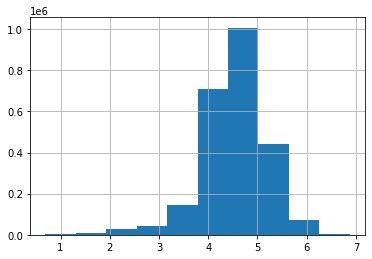

In [4]:
#apparently forgot to run the cell to change text length to log scale
df['text_length'].hist()

In [6]:
df = df.rename(columns={'text_length': 'log_text_length'})
df.columns

Index(['brewery_id', 'beer_id', 'date', 'user_id', 'rating', 'text',
       'nbr_reviews', 'location_user', 'location_brewery', 'location_match',
       'flesch_reading_ease', 'dale_chall_readability_score',
       'log_text_length', 'time0', 'relative_time', 'log_scaled_relative_time',
       'log_scaled_absolute_time', 'number_reviews_left', 'average_rating',
       'rating_diff', 'lower/higher', 'West Coast', 'Northern Europe',
       'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
       'Oceania', 'Southern Europe', 'South', 'Asia', 'Canada', 'Central',
       'Non-Contiguous', 'Central America', 'Africa', 'South America',
       'Non-Contuguous'],
      dtype='object')

<AxesSubplot:>

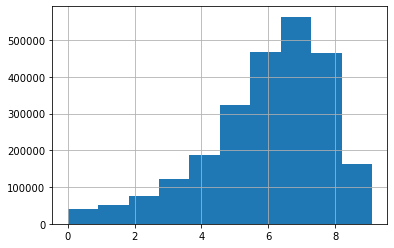

In [8]:
np.log(df['nbr_reviews']).hist()

In [9]:
#also forgot to log-scale 'nbr_reviews'
df['nbr_reviews'] = np.log(df['nbr_reviews'])
df = df.rename(columns={'nbr_reviews': 'log_nbr_reviews'})
df.columns

Index(['brewery_id', 'beer_id', 'date', 'user_id', 'rating', 'text',
       'log_nbr_reviews', 'location_user', 'location_brewery',
       'location_match', 'flesch_reading_ease', 'dale_chall_readability_score',
       'log_text_length', 'time0', 'relative_time', 'log_scaled_relative_time',
       'log_scaled_absolute_time', 'number_reviews_left', 'average_rating',
       'rating_diff', 'lower/higher', 'West Coast', 'Northern Europe',
       'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
       'Oceania', 'Southern Europe', 'South', 'Asia', 'Canada', 'Central',
       'Non-Contiguous', 'Central America', 'Africa', 'South America',
       'Non-Contuguous'],
      dtype='object')

In [10]:
#There was a typo in the Non-Contuguous vs Non-Contiguous
df['Non-Contiguous'] += df['Non-Contuguous']

In [11]:
X = df[[
       'log_nbr_reviews', 'location_match', 'flesch_reading_ease', 'dale_chall_readability_score','log_text_length', 'log_scaled_relative_time', 'log_scaled_absolute_time', 
       'West Coast', 'Northern Europe',
       'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
       'Oceania', 'Southern Europe', 'South', 'Asia', 'Canada', 'Central',
       'Non-Contiguous', 'Central America', 'Africa', 'South America',
       ]]
Y = df[['rating_diff', 'lower/higher']]

X.to_csv('Data/X.csv', index=False)
Y.to_csv('Data/Y.csv', index=False)

### Group features by "topic"

To understand the amount of variance explained by each feature we need to see the average difference in R^2 score of the fit every time we introduce a new variable (averaged over all the permutation of the order of introduction) { https://stats.stackexchange.com/tags/variance-decomposition/info }

In [2]:
X = pd.read_csv('Data/X.csv')
X.columns

Index(['log_nbr_reviews', 'location_match', 'flesch_reading_ease',
       'dale_chall_readability_score', 'log_text_length',
       'log_scaled_relative_time', 'log_scaled_absolute_time', 'West Coast',
       'Northern Europe', 'East Coast', 'Midwest', 'Western Europe',
       'Central and Eastern Europe', 'Oceania', 'Southern Europe', 'South',
       'Asia', 'Canada', 'Central', 'Non-Contiguous', 'Central America',
       'Africa', 'South America'],
      dtype='object')

In [23]:
columns_grouped = [('log_nbr_reviews'), 
                   ('location_match'), 
                   ('flesch_reading_ease',
                    'dale_chall_readability_score', 'log_text_length'),
                   ('log_scaled_absolute_time', 'log_scaled_relative_time'),
                   ('West Coast', 'Northern Europe',
                    'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
                    'Oceania', 'Southern Europe', 'South', 'Asia', 'Central', 'Canada',
                    'Non-Contiguous', 'South America', 'Central America', 'Africa')
                  ]
len(columns_grouped)

5

In [24]:
from itertools import permutations 

Perms = permutations(columns_grouped)
Perms = [p for p in Perms]
Perms

[('log_nbr_reviews',
  'location_match',
  ('flesch_reading_ease', 'dale_chall_readability_score', 'log_text_length'),
  ('log_scaled_absolute_time', 'log_scaled_relative_time'),
  ('West Coast',
   'Northern Europe',
   'East Coast',
   'Midwest',
   'Western Europe',
   'Central and Eastern Europe',
   'Oceania',
   'Southern Europe',
   'South',
   'Asia',
   'Central',
   'Canada',
   'Non-Contiguous',
   'South America',
   'Central America',
   'Africa')),
 ('log_nbr_reviews',
  'location_match',
  ('flesch_reading_ease', 'dale_chall_readability_score', 'log_text_length'),
  ('West Coast',
   'Northern Europe',
   'East Coast',
   'Midwest',
   'Western Europe',
   'Central and Eastern Europe',
   'Oceania',
   'Southern Europe',
   'South',
   'Asia',
   'Central',
   'Canada',
   'Non-Contiguous',
   'South America',
   'Central America',
   'Africa'),
  ('log_scaled_absolute_time', 'log_scaled_relative_time')),
 ('log_nbr_reviews',
  'location_match',
  ('log_scaled_absolute_t

In [25]:
len(Perms) #as expected 5!

120

### Normalize input

In [26]:
X.columns

Index(['log_nbr_reviews', 'location_match', 'flesch_reading_ease',
       'dale_chall_readability_score', 'log_text_length',
       'log_scaled_relative_time', 'log_scaled_absolute_time', 'West Coast',
       'Northern Europe', 'East Coast', 'Midwest', 'Western Europe',
       'Central and Eastern Europe', 'Oceania', 'Southern Europe', 'South',
       'Asia', 'Canada', 'Central', 'Non-Contiguous', 'Central America',
       'Africa', 'South America'],
      dtype='object')

In [27]:
to_normalize = ['log_nbr_reviews', 'flesch_reading_ease', 'dale_chall_readability_score', 'log_text_length', 'log_scaled_relative_time', 'log_scaled_absolute_time']
X[to_normalize] = (X[to_normalize] - X[to_normalize].mean())/X[to_normalize].std()
X

,log_nbr_reviews,location_match,flesch_reading_ease,dale_chall_readability_score,log_text_length,log_scaled_relative_time,log_scaled_absolute_time,West Coast,Northern Europe,East Coast,...,Oceania,Southern Europe,South,Asia,Canada,Central,Non-Contiguous,Central America,Africa,South America
0,0.096903,0,-2.176083,0.974773,-0.163428,-1.854764,0.908146,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.615788,1,-0.443363,0.796812,-0.622884,-1.642623,0.930304,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.096903,0,-1.501745,1.113186,-0.647544,-0.656073,0.908146,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.015829,0,-0.129064,-0.448911,0.517412,-1.305399,0.739181,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.359272,0,-1.226393,-1.239846,-1.732230,-0.008302,1.255585,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,-2.877143,1,-0.797063,2.866427,-0.750475,-1.854764,1.601088,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2457790,-3.255468,0,-1.563789,3.413490,-5.116885,-1.429779,1.397163,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2457791,-3.255468,1,0.198821,-1.061886,-2.078056,-1.854764,1.348602,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2457792,-2.498818,1,0.341479,-0.350044,0.806404,-1.266542,1.407116,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Add intercept

We add column of 1s so that it will effectively be the intercept and we can separate the effect on the R^2 of the first variable to that of the intercept

In [31]:
X['intercept'] = np.ones(len(X))
X

,log_nbr_reviews,location_match,flesch_reading_ease,dale_chall_readability_score,log_text_length,log_scaled_relative_time,log_scaled_absolute_time,West Coast,Northern Europe,East Coast,...,Southern Europe,South,Asia,Canada,Central,Non-Contiguous,Central America,Africa,South America,intercept
0,0.096903,0,-2.176083,0.974773,-0.163428,-1.854764,0.908146,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,-0.615788,1,-0.443363,0.796812,-0.622884,-1.642623,0.930304,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0.096903,0,-1.501745,1.113186,-0.647544,-0.656073,0.908146,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,1.015829,0,-0.129064,-0.448911,0.517412,-1.305399,0.739181,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
4,0.359272,0,-1.226393,-1.239846,-1.732230,-0.008302,1.255585,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,-2.877143,1,-0.797063,2.866427,-0.750475,-1.854764,1.601088,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2457790,-3.255468,0,-1.563789,3.413490,-5.116885,-1.429779,1.397163,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
2457791,-3.255468,1,0.198821,-1.061886,-2.078056,-1.854764,1.348602,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2457792,-2.498818,1,0.341479,-0.350044,0.806404,-1.266542,1.407116,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0


In [32]:
X.to_csv('Data/X1.csv', index=False)

# Fit

In [35]:
X = pd.read_csv('Data/X1.csv')
Y = pd.read_csv('Data/Y.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
Y #I don't remember how I called the column for continuous regression

,rating_diff,lower/higher
0,-0.2500,-1.0
1,0.2500,1.0
2,-0.0525,-1.0
3,-0.5325,-1.0
4,0.4975,1.0
...,...,...
2457789,0.0550,1.0
2457790,-0.2350,-1.0
2457791,0.2350,1.0
2457792,0.2200,1.0


We should do some bootstrapping to estimate the best value of alpha for ridge. Maybe do it later

In [114]:
columns_grouped = [('log_nbr_reviews'), 
                   ('location_match'), 
                   ('flesch_reading_ease',
                    'dale_chall_readability_score', 'log_text_length'),
                   ('log_scaled_absolute_time', 'log_scaled_relative_time'),
                   ('West Coast', 'Northern Europe',
                    'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
                    'Oceania', 'Southern Europe', 'South', 'Asia', 'Central', 'Canada',
                    'Non-Contiguous', 'South America', 'Central America', 'Africa')
                  ]
topics = ['nbr_reviews', 'location_match', 'text_complexity', 'time', 'location_user']

columns_grouped_perm = list(permutations(columns_grouped))
topics_perm = list(permutations(topics))

In [125]:
def make_into_list(weird_list):  
  a = [item if type(t)==tuple else t for t in weird_list for item in t]  #this makes it into a list but with duplicstes
  seen = set()         
  seen_add = seen.add
  return [x for x in a if not (x in seen or seen_add(x))]     #this removes duplicates while keeping the order
  
r2s = {topic:[] for topic in topics}

#automatically chooses alpha by cross validation
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], fit_intercept=False)  #We use regularization because some of the features have nonzero correlation among them, moreover some might just be noise

for t_p, c_g_p_weird in zip(topics_perm, columns_grouped_perm):
  c_g_p = make_into_list(c_g_p_weird)
  c_g_p.insert(0,'intercept') #add column for intercept in front
  previous_r2 = 0
#   print(c_g_p)
  for i in range(len(c_g_p_weird)):
    if i==0:
      ridge.fit(X[c_g_p[:i+1]].to_numpy().reshape(-1,1), Y['rating_diff'].to_numpy().reshape(-1,1))
      r2 = ridge.score(X_test[c_g_p[:i+1]].to_numpy().reshape(-1,1), Y_test['rating_diff'].to_numpy().reshape(-1,1))
    else:
      ridge.fit(X[c_g_p[:i+1]].to_numpy(), Y['rating_diff'].to_numpy().reshape(-1,1))
      r2 = ridge.score(X_test[c_g_p[:i+1]].to_numpy(), Y_test['rating_diff'].to_numpy().reshape(-1,1))
    if i>0:
      r2s[t_p[i-1]].append(r2-previous_r2)
    previous_r2 = r2
      

In [127]:
#fraction of variance explained by each topic
r2s_mean = {k: np.mean(r2s[k]) for k in r2s.keys()}
r2s_mean

{'nbr_reviews': 0.0018035029518811165,
 'location_match': 0.000841249025232751,
 'text_complexity': 0.0004501430636346439,
 'time': 0.0006184282806208236,
 'location_user': 0.0009966736632032447}

In [133]:
#total fraction of variance explained by the fit
ridge.fit(X_train, Y_train['rating_diff'].to_numpy().reshape(-1,1))
print(ridge.score(X_test, Y_test['rating_diff'].to_numpy().reshape(-1,1)))
ridge.coef_

0.012957625148313112


array([[-0.04403575,  0.02053286,  0.02321455,  0.04266469,  0.02369492,
        -0.01365187, -0.00828723, -0.02425619, -0.04080991,  0.00265972,
         0.00170786, -0.03052455,  0.06212661, -0.03868658, -0.11973091,
         0.01666672,  0.02362636, -0.00574089, -0.00776229,  0.07477254,
         0.09046613,  0.01373783, -0.02519005, -0.0069376 ]])

In [137]:
#weight of the model
weights = {}
for col,coef in zip(X.columns, ridge.coef_.flatten()):
  weights[col] = coef
weights

{'log_nbr_reviews': -0.04403575411867111,
 'location_match': 0.02053285975584629,
 'flesch_reading_ease': 0.023214547120744555,
 'dale_chall_readability_score': 0.04266468763299258,
 'log_text_length': 0.023694920990948276,
 'log_scaled_relative_time': -0.013651867625299019,
 'log_scaled_absolute_time': -0.008287229940776797,
 'West Coast': -0.024256187542647467,
 'Northern Europe': -0.04080990978130217,
 'East Coast': 0.0026597173569768984,
 'Midwest': 0.0017078592655472846,
 'Western Europe': -0.03052455269040877,
 'Central and Eastern Europe': 0.062126610301355356,
 'Oceania': -0.038686580791594594,
 'Southern Europe': -0.11973090810223752,
 'South': 0.016666719424605958,
 'Asia': 0.023626362279095314,
 'Canada': -0.005740886948336826,
 'Central': -0.007762286991354284,
 'Non-Contiguous': 0.07477253841080511,
 'Central America': 0.09046612841707358,
 'Africa': 0.01373782833347148,
 'South America': -0.0251900491277528,
 'intercept': -0.006937598194628691}

From this we can see that the "topic" that mostly explains the variance in the difference between the average rating for a beer and the rating given by a review is the number of reviews; in particular, being the coefficient negative, the more reviews a user does, the harsher they are. 

But do they become harsher or start also start by giving lower scores?

We might explain this further by looking at the evolution of the difference between average rating and rating in time for "single" user

# Add time of review relative to when the user joined

In [2]:
df = pd.read_csv('Data/checkpoint7.csv')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,Southern Europe,South,Asia,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,...,0,0,0,0,0,0,0,0,0,0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,...,0,0,0,0,0,0,0,0,0,0
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,...,0,0,0,0,0,0,0,0,0,0
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,...,0,0,0,0,0,0,0,0,0,0
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,...,0,0,1,0,0,0,0,0,0,0


In [3]:
users = pd.read_csv('Data/BeerAdvocate/users.csv')
users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


In [4]:
df = df.rename(columns={'log_scaled_relative_time': 'log_scaled_relative_time_beer'})

In [5]:
user_joined = users[['user_id', 'joined']]
df = df.merge(user_joined, on='user_id', how='outer')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,South,Asia,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous,joined
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
1,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
2,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
3,31221.0,120799.0,1.409306e+09,nmann08.184925,3.25,"On draft, pours a hazy pale yellow, very froth...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
4,31221.0,133715.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a slightly hazy pale orange, w...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545003,NaN,NaN,NaN,egroves.813240,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.403777e+09
2545004,NaN,NaN,NaN,llgarrity.884995,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.414580e+09
2545005,NaN,NaN,NaN,lgkiii.1077659,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.449313e+09
2545006,NaN,NaN,NaN,eturchick.374415,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.253959e+09


In [6]:
len1 = len(df)
df = df.dropna()
print(f'we dropped {len1-len(df)} rows')
df

we dropped 87214 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,South,Asia,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous,joined
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
1,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
2,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
3,31221.0,120799.0,1.409306e+09,nmann08.184925,3.25,"On draft, pours a hazy pale yellow, very froth...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
4,31221.0,133715.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a slightly hazy pale orange, w...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.501236e+09,tarcy.712977,3.98,A good Helles is hard to find. I found it here!,1.0,West Coast,West Coast,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.358075e+09
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.358593e+09
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404727e+09
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.455188e+09


<ipython-input-7-be326478c43f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_after_joining'] = df['date'] - df['joined']


<AxesSubplot:>

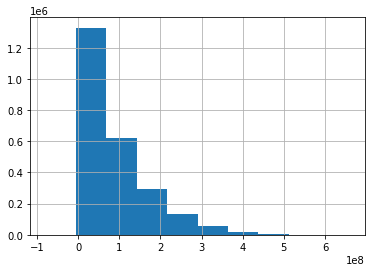

In [7]:
df['time_after_joining'] = df['date'] - df['joined']
df['time_after_joining'].hist()

<AxesSubplot:>

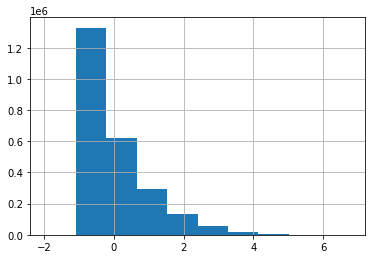

In [8]:
#look for best scale
#just normalize
((df['time_after_joining'] - df['time_after_joining'].mean())/df['time_after_joining'].std()).hist()

/home/alessandro/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

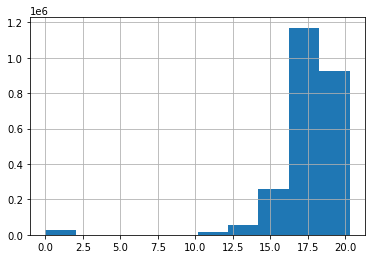

In [9]:
a = np.log(df['time_after_joining']+1)
a.hist()

<AxesSubplot:>

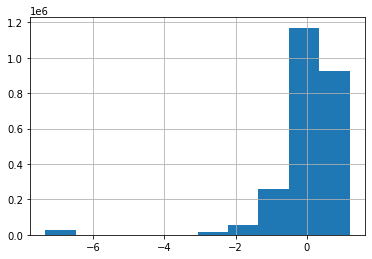

In [10]:
((a-a.mean())/a.std()).hist()

In [11]:
#better to take the log
df['log_time_after_joining'] = np.log(df['time_after_joining']+1)
#df = df.rename(columns={'time_after_joining': 'log_time_after_joining'})
df

<ipython-input-11-506221f767a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_time_after_joining'] = np.log(df['time_after_joining']+1)


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous,joined,time_after_joining,log_time_after_joining
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
1,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
2,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
3,31221.0,120799.0,1.409306e+09,nmann08.184925,3.25,"On draft, pours a hazy pale yellow, very froth...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
4,31221.0,133715.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a slightly hazy pale orange, w...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.501236e+09,tarcy.712977,3.98,A good Helles is hard to find. I found it here!,1.0,West Coast,West Coast,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.358075e+09,143161200.0,18.779482
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.358593e+09,113007600.0,18.542966
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404727e+09,60566400.0,17.919251
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.455188e+09,17708400.0,16.689550


In [12]:
df.columns

Index(['brewery_id', 'beer_id', 'date', 'user_id', 'rating', 'text',
       'nbr_reviews', 'location_user', 'location_brewery', 'location_match',
       'flesch_reading_ease', 'dale_chall_readability_score', 'text_length',
       'time0', 'relative_time', 'log_scaled_relative_time_beer',
       'log_scaled_absolute_time', 'number_reviews_left', 'average_rating',
       'rating_diff', 'lower/higher', 'West Coast', 'Northern Europe',
       'East Coast', 'Midwest', 'Western Europe', 'Central and Eastern Europe',
       'Oceania', 'Southern Europe', 'South', 'Asia', 'Canada', 'Central',
       'Non-Contiguous', 'Central America', 'Africa', 'South America',
       'Non-Contuguous', 'joined', 'time_after_joining',
       'log_time_after_joining'],
      dtype='object')

In [13]:
df[df.isna().any(axis=1)]

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous,joined,time_after_joining,log_time_after_joining
71690,112.0,403.0,1.329304e+09,bmmillsy.659902,2.42,Bottle from The Wine Seller in A2. Pours a haz...,1576.0,South,West Coast,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.329390e+09,-86400.0,NaN
71743,140.0,276.0,1.329304e+09,bmmillsy.659902,3.71,The classic APA. Pours a nice light copper col...,1576.0,South,West Coast,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.329390e+09,-86400.0,NaN
71773,610.0,2751.0,1.329304e+09,bmmillsy.659902,4.27,Bomber from the shop. Pours a clear golden col...,1576.0,South,West Coast,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.329390e+09,-86400.0,NaN
71787,147.0,4083.0,1.329304e+09,bmmillsy.659902,4.38,Pours golden and clear with medium white head....,1576.0,South,West Coast,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.329390e+09,-86400.0,NaN
71872,262.0,30970.0,1.329304e+09,bmmillsy.659902,3.22,Pours a light copper with white head. Aroma of...,1576.0,South,East Coast,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.329390e+09,-86400.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456572,1133.0,27000.0,1.188986e+09,sukaluski.157032,2.61,A: Pale amber with orange highlights. Slight c...,1.0,East Coast,East Coast,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.189073e+09,-86400.0,NaN
2456579,797.0,7436.0,1.089540e+09,lpatron.7252,1.00,Without a doubt the absolute worst beer I have...,1.0,West Coast,West Coast,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.089626e+09,-86400.0,NaN
2456581,4234.0,9003.0,1.183457e+09,hershelgibbs.146120,4.53,This is one of my favorite microbrew beers I h...,1.0,Midwest,Midwest,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.183543e+09,-86400.0,NaN
2456796,14660.0,38721.0,1.190282e+09,jordanweeks.159947,2.52,"Opaque black stout, with a tight white head. L...",3.0,South,South,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.190369e+09,-86400.0,NaN


In [14]:
#there must have been a problem because there are some (1240) reviews apparently written before joining. 
#It's probably a defect in the data since the time difference seems to always be -86400.0
#We'll get rid of them
len1 = len(df)
df = df.dropna()
print(f'we dropped {len1-len(df)} rows')
df

we dropped 1240 rows


,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,Canada,Central,Non-Contiguous,Central America,Africa,South America,Non-Contuguous,joined,time_after_joining,log_time_after_joining
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
1,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
2,31221.0,135343.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours a dark brown, pretty much opaq...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
3,31221.0,120799.0,1.409306e+09,nmann08.184925,3.25,"On draft, pours a hazy pale yellow, very froth...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
4,31221.0,133715.0,1.409306e+09,nmann08.184925,3.75,"On draft, pours a slightly hazy pale orange, w...",465.0,West Coast,Northern Europe,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199704e+09,209602800.0,19.160725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.501236e+09,tarcy.712977,3.98,A good Helles is hard to find. I found it here!,1.0,West Coast,West Coast,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.358075e+09,143161200.0,18.779482
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.358593e+09,113007600.0,18.542966
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404727e+09,60566400.0,17.919251
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.455188e+09,17708400.0,16.689550


In [20]:
X = (df[['log_time_after_joining']] - df[['log_time_after_joining']].mean())/df[['log_time_after_joining']].std()
Y = df[['rating_diff']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)
lr = LinearRegression().fit(X_train, Y_train)

lr.score(X_test, Y_test)

0.003031799825864767

In [21]:
lr.coef_

array([[-0.02575148]])

### Look at evolution overtime for a single user [not inckuded in data story]

In [36]:
lr = LinearRegression()
coeffs = []
users_sorted = df.groupby('user_id')['nbr_reviews'].mean().sort_values(ascending=False)[:1000]
for user in users_sorted.index:
  df1 = df[df['user_id']==user]
  X = (df1[['log_time_after_joining']] - df1[['log_time_after_joining']].mean())/df1[['log_time_after_joining']].std()
  Y = df1[['rating_diff']]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)
  lr.fit(X_train, Y_train)
  coeffs.append(float(lr.coef_))
  

(array([  2182.,   5274.,   4078.,  42771., 154459., 448153., 437003.,
        171815.,  44675.,  10015.]),
 array([-0.22521841, -0.18925578, -0.15329314, -0.1173305 , -0.08136786,
        -0.04540522, -0.00944259,  0.02652005,  0.06248269,  0.09844533,
         0.13440797]),
 <BarContainer object of 10 artists>)

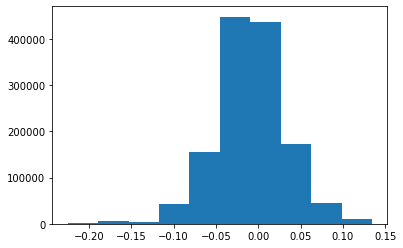

In [38]:
plt.hist(coeffs, weights=users_sorted.values) #weighting with the number of reviews done by each user

(array([  1.,   4.,   6.,  34., 109., 318., 340., 141.,  38.,   9.]),
 array([-0.22521841, -0.18925578, -0.15329314, -0.1173305 , -0.08136786,
        -0.04540522, -0.00944259,  0.02652005,  0.06248269,  0.09844533,
         0.13440797]),
 <BarContainer object of 10 artists>)

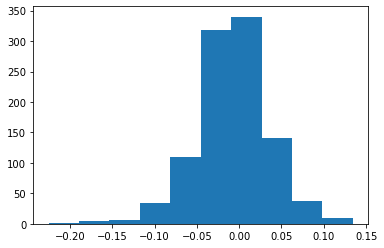

In [39]:
plt.hist(coeffs)

In [41]:
np.mean(coeffs)

-0.007499964897247414

In [45]:
np.average(coeffs, weights=users_sorted.values)

-0.00911462726766377

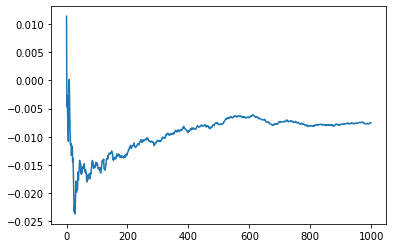

In [46]:
a = np.cumsum(coeffs)
b = a/np.arange(1,len(a)+1)
plt.plot(np.arange(len(a)),b)

# Make plots [mainly for us, not beautiful code]

### Rating distribution

In [7]:
df = pd.read_csv('Data/checkpoint6.csv')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left,average_rating,rating_diff,lower/higher
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,...,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2,3.7500,-0.2500,-1.0
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,...,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2,3.7500,0.2500,1.0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,...,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28,4.0525,-0.0525,-1.0
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,...,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28,4.0525,-0.5325,-1.0
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,...,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28,4.0525,0.4975,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,...,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2,4.0350,0.0550,1.0
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,...,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2,4.3450,-0.2350,-1.0
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,...,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2,4.3450,0.2350,1.0
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,...,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2,3.4200,0.2200,1.0


In [8]:
#intra-beer std
sds = df.groupby('beer_id')['rating_diff'].std().values
#overall std
sd_overall = df['rating_diff'].std()
#weighting by number of reviews for a given beer
weight = df.groupby('beer_id')['rating_diff'].count().values

In [9]:
df5 = pd.read_csv('Data/checkpoint5.csv')
std_between_beers = df5.groupby('beer_id').mean()[['rating']].std()
std_between_beers

rating    0.463636
dtype: float64

In [10]:
print(sd_overall, sds.mean())

0.44976817964523996 0.38816644496476826


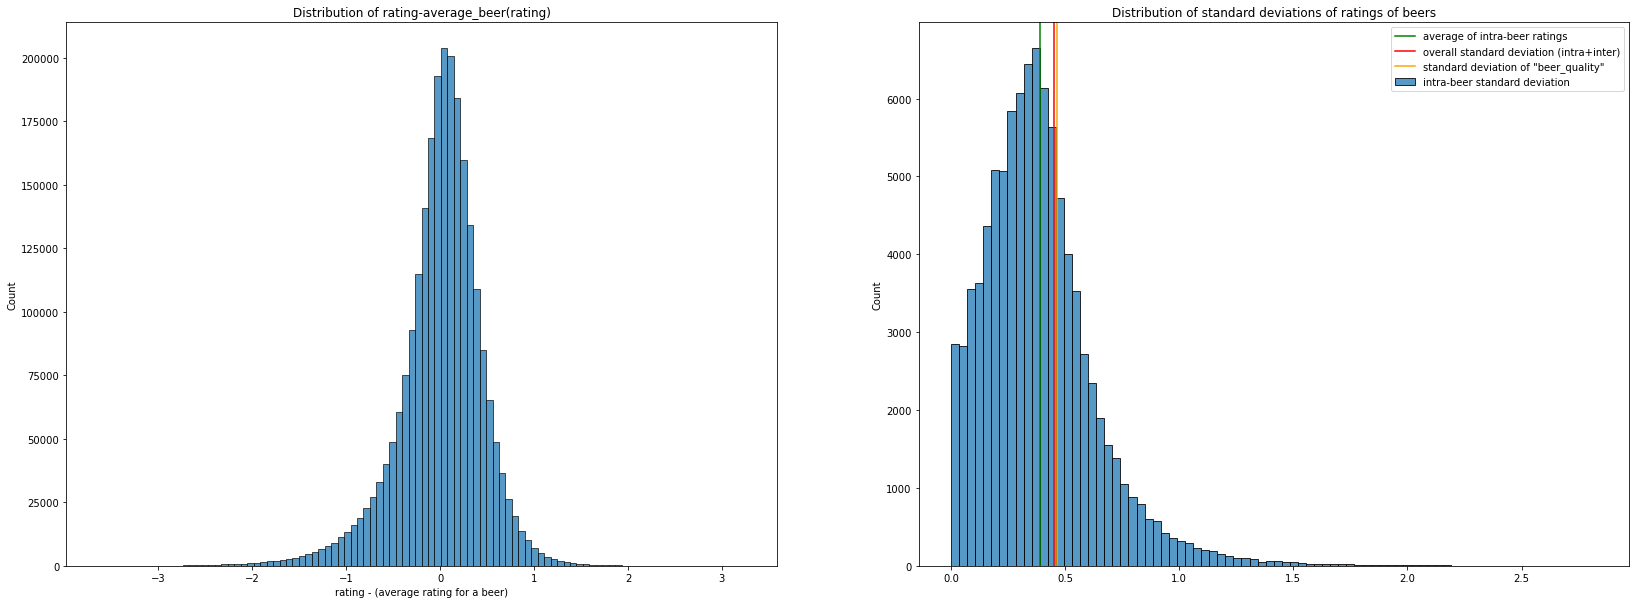

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(28,10))

sns.histplot(data=df['rating_diff'], bins=100, ax=ax1)
ax1.set_title('Distribution of rating-average_beer(rating)')
ax1.set_xlabel('rating - (average rating for a beer)')

sns.histplot(data=sds, label='intra-beer standard deviation', bins=80, ax=ax2)
ax2.axvline(sds.mean(), color='green', label='average of intra-beer ratings')
ax2.axvline(sd_overall, color='red', label='overall standard deviation (intra+inter)')
ax2.axvline(std_between_beers.values, color='orange', label='standard deviation of "beer_quality"')
ax2.legend()
ax2.set_title('Distribution of standard deviations of ratings of beers')

plt.savefig('Personal_taste_distribution_fig1.jpg')

<ipython-input-12-c09e5dc7936c>:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

<ipython-input-12-c09e5dc7936c>:18: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



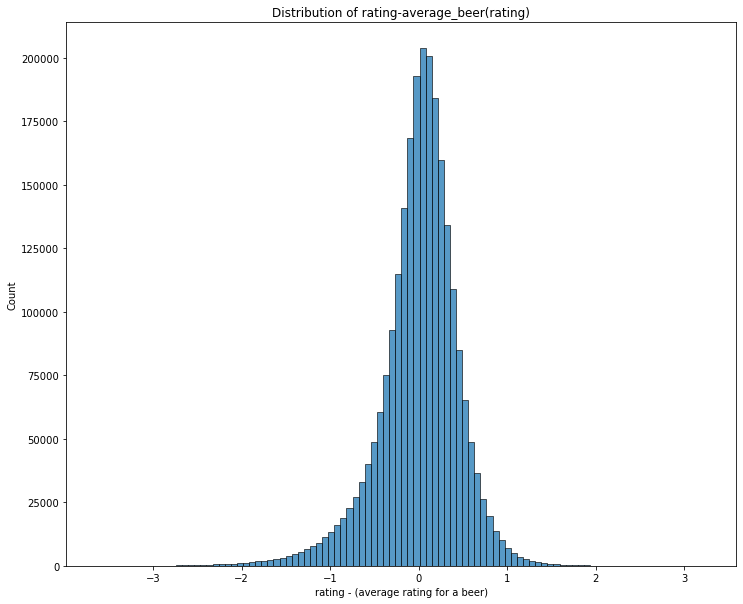

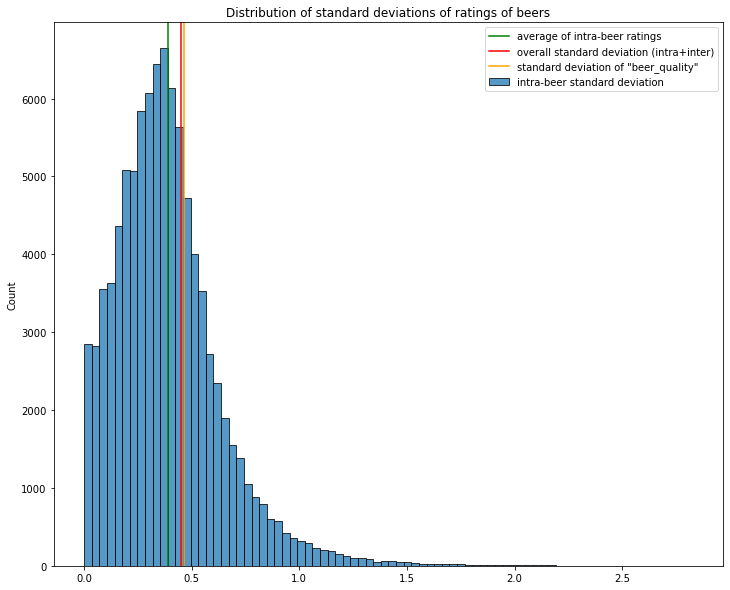

In [12]:
fig, ax1 = plt.subplots( figsize=(12,10))

sns.histplot(data=df['rating_diff'], bins=100, ax=ax1)
ax1.set_title('Distribution of rating-average_beer(rating)')
ax1.set_xlabel('rating - (average rating for a beer)')
plt.savefig('Personal_taste_distribution_fig1.jpg')
fig.show()

fig, ax2 = plt.subplots( figsize=(12,10))

sns.histplot(data=sds, label='intra-beer standard deviation', bins=80, ax=ax2)
ax2.axvline(sds.mean(), color='green', label='average of intra-beer ratings')
ax2.axvline(sd_overall, color='red', label='overall standard deviation (intra+inter)')
ax2.axvline(std_between_beers.values, color='orange', label='standard deviation of "beer_quality"')
ax2.legend()
ax2.set_title('Distribution of standard deviations of ratings of beers')
plt.savefig('Personal_taste_distribution_fig2.jpg')
fig.show()

In [112]:
#check for normality of left plot
scipy.stats.normaltest(df['rating_diff'])

NormaltestResult(statistic=407697.52982394083, pvalue=0.0)

In [113]:
df['rating_diff'].std()

0.44976817964523996

In [2]:
df = pd.read_csv('Data/checkpoint6.csv')
df

,brewery_id,beer_id,date,user_id,rating,text,nbr_reviews,location_user,location_brewery,location_match,...,dale_chall_readability_score,text_length,time0,relative_time,log_scaled_relative_time,log_scaled_absolute_time,number_reviews_left,average_rating,rating_diff,lower/higher
0,31221.0,131646.0,1.409306e+09,nmann08.184925,3.50,"On draft, pours a dark brown with red hues, wi...",465.0,West Coast,Northern Europe,0,...,10.61,4.418841,1.409306e+09,0.0,0.000000,2.645683,2,3.7500,-0.2500,-1.0
1,31221.0,131646.0,1.412071e+09,sam-vw.789622,4.00,"A - Dark brown with a red hue, white fluffy he...",126.0,Northern Europe,Northern Europe,1,...,10.34,4.110874,1.409306e+09,2764800.0,0.244106,2.647643,2,3.7500,0.2500,1.0
2,31221.0,99556.0,1.409306e+09,nmann08.184925,4.00,"On draft, pours an opaque black with a light b...",465.0,West Coast,Northern Europe,0,...,10.82,4.094345,1.379585e+09,29721600.0,1.379310,2.645683,28,4.0525,-0.0525,-1.0
3,31221.0,99556.0,1.388401e+09,stjamesgate.163714,3.52,Unctuous black with a finger of purple-brown f...,2504.0,East Coast,Northern Europe,0,...,8.45,4.875197,1.379585e+09,8816400.0,0.632144,2.630738,28,4.0525,-0.5325,-1.0
4,31221.0,99556.0,1.453288e+09,nilocrellim.694788,4.55,Absolute black color. Very rich clean coffee ...,752.0,Midwest,Northern Europe,0,...,7.25,3.367296,1.379585e+09,73702800.0,2.124687,2.676413,28,4.0525,0.4975,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457789,45456.0,288366.0,1.498385e+09,alphadog.142661,4.09,"Solid Munich lager - clean, clear, pilsy, nobl...",2.0,West Coast,West Coast,1,...,13.48,4.025352,1.498385e+09,0.0,0.000000,2.706973,2,4.0350,0.0550,1.0
2457790,34741.0,174990.0,1.471601e+09,kpdoug13.714004,4.11,Great flavor. Delicious.,1.0,East Coast,Midwest,0,...,14.31,1.098612,1.465294e+09,6307200.0,0.489022,2.688936,2,4.3450,-0.2350,-1.0
2457791,34741.0,174990.0,1.465294e+09,carmenrlawrence.821125,4.58,I love this beer. It tastes and feels like a ...,1.0,Midwest,Midwest,1,...,7.52,3.135494,1.465294e+09,0.0,0.000000,2.684641,2,4.3450,0.2350,1.0
2457792,43653.0,209216.0,1.472897e+09,liveoak3000.1106771,3.64,L:It's light yellow (listed as 5 ebc). The be...,4.0,Asia,Asia,1,...,8.60,5.068904,1.463220e+09,9676800.0,0.676855,2.689816,2,3.4200,0.2200,1.0


<AxesSubplot:>

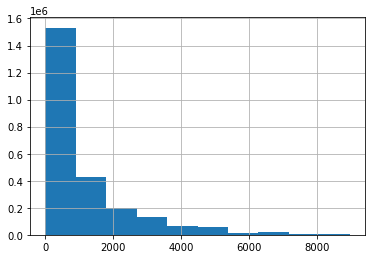

In [3]:
df['nbr_reviews'].hist()

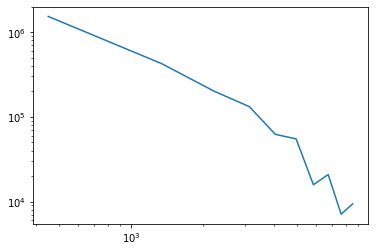

In [42]:
hist, bin_edges = np.histogram(df['nbr_reviews'])
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
plt.loglog(bin_centers, hist)

In [36]:
def linear(x,a,b):
  return a + b*x

def power(x,a,b):
  return a*x**b

param, _ = scipy.optimize.curve_fit(linear, np.log(bin_centers), np.log(hist))
param

array([25.97613198, -1.83117723])

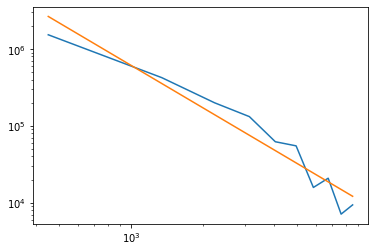

In [37]:
plt.loglog(bin_centers, hist)
plt.loglog(bin_centers, power(bin_centers, np.exp(param[0]), param[1]))

In [4]:
import plotly.express as px


data_var = pd.DataFrame(columns=['category', 'values'], data= [['unexplained', 0.987],  ['explained',0.013]])

fig = px.pie(data_var, values='values', names='category', title= 'Pie chart of the fraction of R squared explained by the metadata')
fig.write_html('variance_explained.html')
fig.show()

data_expl = pd.DataFrame(columns=['category', 'values'], data= [['nbr_reviews', 0.0018035029518811165],
[ 'location_match', 0.000841249025232751],
 ['text_complexity', 0.0004501430636346439],
 ['time', 0.0006184282806208236],
 ['location_user', 0.0009966736632032447]])



fig = px.pie(data_expl, values='values', names='category', title= 'Pie chart of R squared fraction of each metadata among the explained fraction of the R squared')
fig.write_html('variance_decomposition.html')
fig.show()
